In [1]:
import enoki as ek
import numpy as np
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_autodiff_acoustic')
from mitsuba.python.util import traverse
import time
from tqdm.notebook import trange, tqdm

2021-05-21 13:09:20 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [2]:
def estimate_detector_radius(room_dimensions, N):
    return ((15 * room_dimensions[0] * room_dimensions[1] * room_dimensions[2]) / (2 * np.pi * N))**(1/2)

def estimate_max_depth(box_dimensions, max_time, boost=1):
    max_box_distance = np.linalg.norm(box_dimensions) / 2
    max_box_time = max_box_distance / 343
    max_depth_estimate = np.ceil(max_time / max_box_time * boost).astype(int) 
    return max_depth_estimate

def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, 
                       spp, bins, rfilter, max_depth, samples_per_pass, scattering,absorption, hide_sensor=True):
    
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "acoustic",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
                "value": absorption
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "area",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                }
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(bins),
                "rfilter": rfilter
            }  
        },
        "shoebox": {
            "id": "shoebox_ref",
            "type": "shapegroup",
            "bottom": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    translate=[0, 0, -1]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "left": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([0, 1, 0], 90),
                    translate=[-1, 0, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "back": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([1, 0, 0], 90),
                    translate=[0, 1, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "front": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([1, 0, 0], -90),
                    translate=[0, -1, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "right": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([0, 1, 0], -90),
                    translate=[1, 0, 0]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            },
            "top": {
                "type": "rectangle",
                "to_world": transform(
                    scale=[1, 1, 1],
                    rotate=([0, 1, 0], 180),
                    translate=[0, 0, 1]),
                "bsdf": {
                    "type": "ref",
                    "id": "bsdf_neutral"
                }
            }
        },
        "shoebox_instance": {
            "type": "instance",
            "shape": {
                "type": "ref",
                "id": "shoebox_ref"
            },
            "to_world": global_translation * transform(scale=np.array(box_dimensions) / 2)
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in bins),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, size, copy=False):
    return np.array(data, copy=copy).reshape(size)


In [3]:
from mitsuba.core.xml import load_string, load_dict

bins = np.linspace(0.017, 17, 10)
absorption = list(zip(bins, np.random.uniform(0.2, 0.9, 10)))

config = {
    "bins": bins,
    "absorption": absorption,
    "scattering": 0.0,
    "max_time": 1,
    "time_steps": 10,
    "spp": 1000,
    "samples_per_pass": 1000,
    "box_dimensions": [25, 12, 7],
    "emitter_pos": [20, 7, 2],
    "sensor_pos": [9, 6, 1],
    "radius": 1.,  #estimate_detector_radius(box_dimensions, spp)
    "max_depth": 132, #estimate_max_depth(0.9),
    "rfilter": {
        "type": "gaussian",
        "stddev": 0.5
    }
}

scene_dict = make_shoebox_scene(**config)
scene = load_dict(scene_dict)
size = scene.sensors()[0].film().size()

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/acousticbsdf.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/acoustic.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/uniform.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/irregular.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/sphere.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/area.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/d65.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/regular.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/microphone.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/independent.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/tape.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/gaussian.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/shapegroup.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/rectangle.so" ..

2021-05-21 13:09:21 INFO main [ShapeKDTree] Building a SAH kd-tree (6 primitives) ..

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] kd-tree configuration:

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Cost model : SurfaceAreaHeuristic3[
2021-05-21 13:09:21 DEBUG main [TShapeKDTree] query_cost = 20,
2021-05-21 13:09:21 DEBUG main [TShapeKDTree] traversal_cost = 15,
2021-05-21 13:09:21 DEBUG main [TShapeKDTree] empty_space_bonus = 0.9
2021-05-21 13:09:21 DEBUG main [TShapeKDTree] ]

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Max. tree depth : 10

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Scene bounding box (min) : [-1, -1, -1]

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Scene bounding box (max) : [1, 1, 1]

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Min-max bins : 128

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] O(n log n) method : use for <= 65536 primitives

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Stopping primitive count : 3

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Perfect splits : yes

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Retract bad splits : yes

2021-05-21 13:09:21 DEBUG main [TShapeKDTree]

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Creating a preliminary index list (24 B)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Structural kd-tree statistics:

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Primitive references : 6 (24 B)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] kd-tree nodes : 1 (8 B)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] kd-tree depth : 0

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Temporary storage used : 5 MiB

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Parallel work units : 1

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Leaf node histogram : 0(0) 1(0) 2(0) 3(0)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] 4(0) 5(0) 6(1) 7(0)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] 8(0) 9(0) 10(0) 11(0)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] 12(0) 13(0) 14(0) 15(0)

2021-05-21 13:09:21 DEBUG main [TShapeKDTree]

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Qualitative kd-tree statistics:

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Retracted splits : 0

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Bad refines : 0

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Pruned : 0

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Largest leaf node : 6 primitives

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Avg. prims/nonempty leaf : 6.00

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Expected traversals/query : 0.00

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Expected leaf visits/query : 1.00

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Expected prim. visits/query : 6.00

2021-05-21 13:09:21 DEBUG main [TShapeKDTree] Final cost : 120.00

2021-05-21 13:09:21 DEBUG main [TShapeKDTree]

2021-05-21 13:09:21 INFO main [ShapeKDTree] Finished. (32 B of storage, took 22ms)

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/instance.so" ..

2021-05-21 13:09:21 INFO main [PluginManager] Loading plugin "plugins/acousticpath.so" ..

2021-05-21 13:09:21 INFO main [Scene] Building scene in OptiX ..

[0.24654, 0.595258, 0.293094, 0.695374, 0.579955, 0.374448, 0.464589, 0.701561, 0.59232, 0.518196]


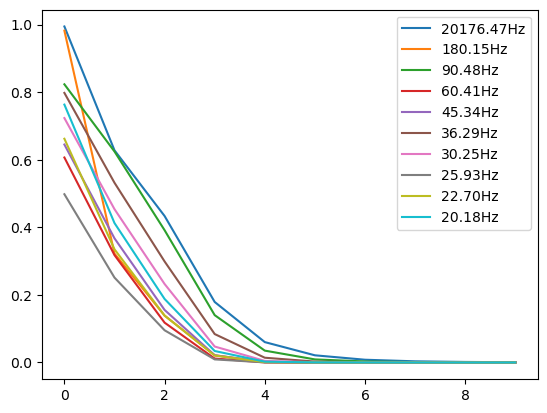

In [4]:
from mitsuba.core import Spectrum, Float

diff_param = 'AcousticBSDF.absorption.values'

params = traverse(scene)
print(params[diff_param])
params.keep([diff_param])
param_ref = Spectrum(params[diff_param])

from mitsuba.python.autodiff import render
hist_ref = render(scene, spp=None)

np_hist_ref = get_vals(hist_ref, size, copy=True)

[plt.plot(np_hist_ref[:,i], label=f"{343 / bins[i]:.2f}Hz") for i in range(len(bins)) ]
plt.legend()
plt.show()

In [5]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class OptimizationPlot:
    def __init__(self, name, bins, target, max_time=1.0):
        self._error = []
        self._bins = bins
        self._max_time = max_time
        
        X = np.linspace(0, len(self._bins), target.shape[1])
        Y = np.linspace(0, self._max_time, target.shape[0])
        X, Y = np.meshgrid(X, Y)
    
        self._fig = go.FigureWidget(make_subplots(rows=1, cols=2, subplot_titles=("Spectogram", "Error"), specs=[[{"type": "surface"}, {"type": "scatter"}]]))
        
        self._fig.update_layout(
            title=name, 
            scene_aspectmode='cube', 
            scene = dict(
                xaxis_title='Frequency [Hz]', 
                yaxis_title='Time [s]', 
                zaxis_title='Energy',
                xaxis = dict(
                    ticktext= [f"{343 / bins[i]:.0f}Hz" for i in range(len(bins))],
                    tickvals= bins
                ),
            ),
            scene_camera =dict(eye=dict(x=2, y=2, z=1)),
            autosize=False,
            width=1600,
            height=800
        )
        
        self._fig.add_surface(row=1, col=1, showscale=False, name="current")
        self._fig.add_surface(row=1, col=1, showscale=False, opacity=0.2, colorscale=['blue', 'blue'], name="target")
        self._fig.add_scatter(row=1, col=2)
                
        self._fig.data[0].x = X
        self._fig.data[0].y = Y
        self._fig.data[1].x = X
        self._fig.data[1].y = Y
        self._fig.data[1].z = target

    def plot_optimization_state(self, current, err_ref):
        self._error.append(err_ref)
        self._fig.data[0].z = current

        self._fig.data[2].y = self._error
        
        time.sleep(0.1)

    @property
    def error(self):
        return self._error
    
    def show(self):
        return self._fig

In [22]:
iterations = 100

def mse(a, b):
    return ek.hsum(ek.sqr(a - b)) / len(a)

params[diff_param] = [0.1] * len(bins)

# Construct an optimizer that will adjust the parameters 'params'
from mitsuba.python.autodiff import Adam, SGD
opt = Adam(params, lr=.2)

opt_plot = OptimizationPlot("10 Bands Adam", config['bins'], np_hist_ref, config['max_time'])
opt_plot.show()

FigureWidget({
    'data': [{'name': 'current',
              'scene': 'scene',
              'showscale': Fal…

In [23]:
pbar = tqdm(range(iterations), desc='iterations')

for it in pbar:
    # Perform a differentiable rendering of the scene
    hist = render(scene, optimizer=opt, unbiased=False, spp=None)

    np_hist = get_vals(hist, size, copy=True)

    # Objective: MSE between 'hist' and 'hist_ref'
    ob_val = mse(hist, hist_ref)

    # Back-propagate errors to input parameters
    ek.backward(ob_val)

    # Optimizer: take a gradient step
    opt.step()

    # Compute error
    err_ref = np.sum(np.square(param_ref - params[diff_param])) / len(param_ref)
    
    pbar.set_postfix({'absorption': params[diff_param]})

    # Plot progress
    opt_plot.plot_optimization_state(np_hist, err_ref)

iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
np.set_printoptions(linewidth=100)

print(diff_param)
print("current:", np.array2string(np.array(params[diff_param]), formatter={'float_kind':lambda x: "%.6f" % x}))
print("target:\t", np.array2string(np.array(param_ref[0]), formatter={'float_kind':lambda x: "%.6f" % x}))

AcousticBSDF.absorption.values
current: [0.258740 0.612103 0.283223 0.692223 0.585171 0.374728 0.461010 0.869384 0.602864 0.502399]
target:	 [0.246540 0.595258 0.293094 0.695374 0.579955 0.374448 0.464589 0.701561 0.592320 0.518196]
